In [62]:
import pandas as pd

# 基本合并（按列名对齐）
df1 = pd.read_csv("DC_bike/202509-tripdata.csv")
df2 = pd.read_csv("DC_bike/202510-tripdata.csv")
out = pd.concat([df1, df2], ignore_index=True)

out["started_at"] = pd.to_datetime(out["started_at"], errors="coerce")

start_bound = pd.Timestamp("2025-09-01 00:00:00")
end_bound   = pd.Timestamp("2025-10-31 23:59:59")

out = out[(out["started_at"] >= start_bound) & (out["started_at"] <= end_bound)]
out = out.drop_duplicates()
out = out.sort_values(by="started_at", ascending=True)
out = out.reset_index(drop=True)

out.to_csv("DC_bike/20250910-tripdata.csv", index=False)

In [65]:
import pandas as pd

df = pd.read_csv("DC_bike/20250910-tripdata.csv", usecols=[
    "started_at", "ended_at",
    "start_lat", "start_lng",
    "end_lat", "end_lng"
])

print(f"line counts before cleaning: {len(df)}")
df = df.dropna(subset=["started_at", "ended_at", "start_lat", "start_lng", "end_lat", "end_lng"])
print(f"line counts after cleaning: {len(df)}")

df["start_location"] = df.apply(lambda row: (row["start_lng"], row["start_lat"]), axis=1)
df["end_location"] = df.apply(lambda row: (row["end_lng"], row["end_lat"]), axis=1)

df = df.rename(columns={
    "started_at": "start_time",
    "ended_at":   "end_time"
})

out = df[["start_time", "start_location", "end_time", "end_location"]]
out.to_csv("DC_bike/bike_network-0910.csv", index=False)

line counts before cleaning: 1249771
line counts after cleaning: 1249057


## Start/end point heat map

In [102]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from shapely.geometry import Point

sns.set_style("white")

# ---------- 配置 ----------
bike_csv        = "DC_bike/20250910-tripdata.csv"   # 你的骑行 CSV 文件路径
boundary_shp    = "DC_bike/gis/ANC_boundary/Advisory_Neighborhood_Commissions_from_2023.shp"
output_folder   = "daily_bike_heatmaps"
os.makedirs(output_folder, exist_ok=True)

# 3. 读入 Virginia COUSUB 并筛选几个县
boundary = gpd.read_file(boundary_shp)
virginia_boundary_path = "DC_bike/gis/tl_2021_51_cousub/tl_2021_51_cousub.shp"
virginia_boundary = gpd.read_file(virginia_boundary_path)
virginia_boundary = virginia_boundary.to_crs(boundary.crs)
virginia_boundary = virginia_boundary[virginia_boundary["COUNTYFP"].isin(["013"])]

alexandira_boundary_path = "DC_bike/gis/Alexandria_boundary/Boundary.shp"
alexandira_boundary = gpd.read_file(alexandira_boundary_path)
alexandira_boundary = alexandira_boundary.to_crs(boundary.crs)
# 6. 合并行政区图层为一个大图层（Maryland + Virginia）
cousub_all = pd.concat([boundary, virginia_boundary, alexandira_boundary], ignore_index=True)

# ---------- 读底图 ----------


# ---------- 读骑行数据 ----------
df = pd.read_csv(
    bike_csv,
    parse_dates=["started_at", "ended_at"],
)

# 新增“日期”列（按开始时间）
df["date"] = df["started_at"].dt.date

# ---------- 构造起点/终点 GeoDataFrame ----------
# 起点：start_lat / start_lng
gdf_start = gpd.GeoDataFrame(
    df.copy(),
    geometry=gpd.points_from_xy(df["start_lng"], df["start_lat"]),
    crs="EPSG:4326"      # 原始是经纬度
)

# 终点：end_lat / end_lng
gdf_end = gpd.GeoDataFrame(
    df.copy(),
    geometry=gpd.points_from_xy(df["end_lng"], df["end_lat"]),
    crs="EPSG:4326"
)

# 投影到和 boundary 一致的坐标系
if boundary.crs is not None:
    gdf_start = gdf_start.to_crs(boundary.crs)
    gdf_end   = gdf_end.to_crs(boundary.crs)
else:
    # 如果 DC 边界没定义 CRS，就给它和点一样
    boundary = boundary.set_crs(gdf_start.crs)

# 统一地图范围（使用 DC 边界扩一点点）
xmin, ymin, xmax, ymax = boundary.total_bounds
dx = (xmax - xmin) * 0.05
dy = (ymax - ymin) * 0.05
xlim = (xmin - dx, xmax + dx)
ylim = (ymin - dy, ymax + dy)

# ---------- 按天绘制 ----------
for date, _ in df.groupby("date"):
    start_day = gdf_start[gdf_start["date"] == date]
    end_day   = gdf_end[gdf_end["date"] == date]

    # 如果这一天数据太少，可以跳过
    if len(start_day) == 0 and len(end_day) == 0:
        continue

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    # 画底图
    for ax in (ax1, ax2):
        cousub_all.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, zorder=2)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.axis("off")

    # ---------- 起点热力 ----------
    if len(start_day) > 0:
        xs = start_day.geometry.x.values
        ys = start_day.geometry.y.values

        sns.kdeplot(
            x=xs,
            y=ys,
            fill=True,
            cmap="YlOrRd",       # 红/黄
            bw_adjust=0.4,       # 越小越“尖锐”
            thresh=0.05,         # 阈值，控制淡区域
            levels=50,
            gridsize=200,
            ax=ax1,
            zorder=0,
        )

    ax1.set_title(f"{date} - Start point", fontsize=14)

    # colorbar（相对密度）
    norm_in = mpl.colors.Normalize(vmin=0, vmax=1)
    sm_in   = mpl.cm.ScalarMappable(cmap="YlOrRd", norm=norm_in)
    sm_in.set_array([])
    cbar1 = fig.colorbar(sm_in, ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label("Relative density (starts)")

    # ---------- 终点热力 ----------
    if len(end_day) > 0:
        xs = end_day.geometry.x.values
        ys = end_day.geometry.y.values

        sns.kdeplot(
            x=xs,
            y=ys,
            fill=True,
            cmap="GnBu",         # 绿/蓝
            bw_adjust=0.4,
            thresh=0.05,
            levels=50,
            gridsize=200,
            ax=ax2,
            zorder=0,
        )

    ax2.set_title(f"{date} - End point", fontsize=14)

    norm_out = mpl.colors.Normalize(vmin=0, vmax=1)
    sm_out   = mpl.cm.ScalarMappable(cmap="GnBu", norm=norm_out)
    sm_out.set_array([])
    cbar2 = fig.colorbar(sm_out, ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_label("Relative density (ends)")

    plt.suptitle(f"Bike trip start/end heatmaps on {date}", fontsize=16)
    plt.tight_layout()
    out_path = os.path.join(output_folder, f"bike_heatmap_{date}.png")
    plt.savefig(out_path, dpi=300)
    plt.close(fig)

Make film

In [104]:
from moviepy.editor import ImageSequenceClip
import os

folder = "daily_maps_heatmap"
files = sorted(
    [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".png")]
)

clip = ImageSequenceClip(files, fps=5)
clip.write_videofile("bike_daily_heatmap.mp4", codec="libx264")

ModuleNotFoundError: No module named 'moviepy.editor'

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import distinctipy
import itertools
import os
import re
import glob

def plot_community_map(
    streets_shp_path,
    partition_csv_path,
    districts_shp_path,
    out_path=None,
    draw_district_labels=True,
    title_text=None,          # 新增：自定义标题
    show_legend=True          # 新增：控制 legend
):
    # 1) 读数据
    gdf_streets = gpd.read_file(streets_shp_path)
    df_partition = pd.read_csv(partition_csv_path)
    gdf_districts = gpd.read_file(districts_shp_path)

    if gdf_districts.crs != gdf_streets.crs:
        gdf_districts = gdf_districts.to_crs(gdf_streets.crs)

    # 3) 合并 partition
    merged = gdf_streets.merge(df_partition, how="left", left_on="NAME", right_on="anc")

    # 4) 颜色 + 图案
    communities = sorted(merged["community_id"].dropna().unique())
    num_comms = len(communities)
    colors = distinctipy.get_colors(num_comms) if num_comms > 0 else []
    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
    hatch_cycle = itertools.cycle(hatches)

    # 5) 绘图
    fig, ax = plt.subplots(figsize=(12, 12))

    # （A）先画未分配街道（灰色底+黑边）
    merged[merged["community_id"].isna()].plot(
        color="lightgray", edgecolor="black", linewidth=0.4, ax=ax, label="未分配"
    )

    legend_patches = []
    for color, cid in zip(colors, communities):
        hatch = next(hatch_cycle)
        subset = merged[merged["community_id"] == cid]
        subset.plot(
            facecolor=color,
            edgecolor="black",
            linewidth=0.5,
            hatch=hatch,
            ax=ax
        )
        legend_patches.append(
            mpatches.Patch(facecolor=color, edgecolor="black", hatch=hatch, label=f"Community {int(cid)}")
        )

    # 区界与标注
    gdf_districts.boundary.plot(ax=ax, edgecolor="red", linewidth=1.2, zorder=10)
    if draw_district_labels and "NAME" in gdf_districts.columns:
        for _, row in gdf_districts.iterrows():
            try:
                pt = row.geometry.representative_point()
                ax.text(
                    pt.x, pt.y,
                    str(row["NAME"]),
                    fontsize=9, fontweight="bold",
                    ha="center", va="center",
                    bbox=dict(facecolor="white", edgecolor="none", alpha=0.6, boxstyle="round,pad=0.2")
                )
            except Exception:
                pass

    # 图例可控
    if show_legend and legend_patches:
        ax.legend(
            handles=legend_patches,
            title="Community label",
            loc="upper left",
            bbox_to_anchor=(1.02, 1),
            borderaxespad=0,
            fontsize=9
        )

    # 标题可控
    ax.set_title(title_text if title_text else "Static bike community", fontsize=15, fontweight="bold")
    ax.axis("off")

    plt.tight_layout()
    if out_path is not None:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    return merged


# =============== 主程序：批量读取每天的 partition 并绘图 ===============
if __name__ == "__main__":
    streets_shp_path   = "DC_bike/gis/Single_Member_District_from_2023.shp"
    districts_shp_path = "DC_bike/gis/Advisory_Neighborhood_Commissions_from_2023.shp"

    partition_dir = "output/DC_bike/daily_partition"         # 输入目录
    out_dir       = "plot/DC_bikeplot/daily_partition"       # 输出目录
    os.makedirs(out_dir, exist_ok=True)

    # 遍历所有 CSV（例如 anc_partition-2025-09-01.csv）
    csv_paths = sorted(glob.glob(os.path.join(partition_dir, "*.csv")))
    if not csv_paths:
        print(f"未在 {partition_dir} 找到任何 CSV。")
    for csv_path in csv_paths:
        fname = os.path.basename(csv_path)
        # 从文件名提取日期（YYYY-MM-DD）
        m = re.search(r"(\d{4}-\d{2}-\d{2})", fname)
        day_str = m.group(1) if m else "unknown-date"

        out_path = os.path.join(out_dir, f"community_map-{day_str}.png")
        print(f"绘制 {day_str} -> {out_path}")

        # 不要 legend，标题为当天日期
        plot_community_map(
            streets_shp_path=streets_shp_path,
            partition_csv_path=csv_path,
            districts_shp_path=districts_shp_path,
            out_path=out_path,
            draw_district_labels=True,
            title_text=day_str,
            show_legend=False
        )

    print(f"完成。图片已保存至：{out_dir}")

绘制 2025-09-01 -> plot/DC_bikeplot/daily_partition/community_map-2025-09-01.png
绘制 2025-09-02 -> plot/DC_bikeplot/daily_partition/community_map-2025-09-02.png
绘制 2025-09-03 -> plot/DC_bikeplot/daily_partition/community_map-2025-09-03.png
绘制 2025-09-04 -> plot/DC_bikeplot/daily_partition/community_map-2025-09-04.png
绘制 2025-09-05 -> plot/DC_bikeplot/daily_partition/community_map-2025-09-05.png
绘制 2025-09-06 -> plot/DC_bikeplot/daily_partition/community_map-2025-09-06.png
绘制 2025-09-07 -> plot/DC_bikeplot/daily_partition/community_map-2025-09-07.png
绘制 2025-09-08 -> plot/DC_bikeplot/daily_partition/community_map-2025-09-08.png
绘制 2025-09-09 -> plot/DC_bikeplot/daily_partition/community_map-2025-09-09.png
绘制 2025-09-10 -> plot/DC_bikeplot/daily_partition/community_map-2025-09-10.png
绘制 2025-09-11 -> plot/DC_bikeplot/daily_partition/community_map-2025-09-11.png
绘制 2025-09-12 -> plot/DC_bikeplot/daily_partition/community_map-2025-09-12.png
绘制 2025-09-13 -> plot/DC_bikeplot/daily_partition/co

In [40]:
import geopandas as gpd


file_path = "DC_bike/gis/Single_Member_District_from_2023.shp"
gdf = gpd.read_file(file_path)
gdf.head(2)

,SMD_ID,ANC_ID,WEB_URL,NAME,CHAIR,REP_NAME,LAST_NAME,FIRST_NAME,ADDRESS,MIDDLE_NAM,...,PHONE,EMAIL,SE_ANNO_CA,GLOBALID,CREATED,EDITED,OBJECTID,SHAPEAREA,SHAPELEN,geometry
0,1C08,1C,https://anc1c.org/,SMD 1C08,PETER WOOD,DAVID FUCILLO,FUCILLO,DAVID,2440 16TH ST NE,None,...,None,1C08@anc.dc.gov,None,{71F7E6FE-D54A-4AB5-A1C3-35D6545D00E4},2022-12-21,2025-04-25,2906,0,0,"POLYGON ((-8575662.858 4710610.78, -8575662.76..."
1,1C07,1C,https://anc1c.org/,SMD 1C07,PETER WOOD,JEAN EVANS,FALESCHINI,JAKE,2205 CHAMPLAIN STREET NW\n,None,...,None,1C07@anc.dc.gov,None,{B49A608D-FFA3-4459-836F-9F7F056773FB},2022-12-21,2025-01-08,2907,0,0,"POLYGON ((-8575962.446 4710924.908, -8575959.0..."


In [ ]:
import geopandas as gpd

gdf = gpd.read_file("DC_bike/gis/ANC_boundary/Advisory_Neighborhood_Commissions_from_2023.shp")

In [34]:
import geopandas as gpd

DC_boundary = gpd.read_file("DC_bike/gis/Washington_DC_Boundary/Washington_DC_Boundary.shp")
DC_boundary.head(2)

,CITY_NAME,STATE_CITY,CAPITAL,WEB_URL,AREAKM,AREAMILES,GIS_ID,GLOBALID,CREATED,EDITED,OBJECTID,SHAPEAREA,SHAPELEN,geometry
0,Washington,1150000,Y,http://www.dc.gov,177.47,68.52,DCBndyPly_1,{ED39E1E0-B1E5-4B42-BE73-1C737B39E5CA},None,None,1,0,0,"POLYGON ((-8584936.334 4712272.261, -8584936.2..."


# Train

In [2]:
import pandas as pd

train_df = pd.read_excel("DC_bike/rail_OD_092225_110725.xlsx")
train_df.head()

,Entry date,Entry station,Exit station,Trips
0,2025-09-22,Addison Road,Anacostia,11
1,2025-09-22,Addison Road,Archives,25
2,2025-09-22,Addison Road,Arlington Cemetery,5
3,2025-09-22,Addison Road,Ballston-MU,9
4,2025-09-22,Addison Road,Benning Road,67


In [3]:
station_name_mapping = dict(
    {"Mt Vernon Sq": "Mt Vernon Sq 7th St-Convention Center",
     "Gallery Place": "Gallery Pl-Chinatown",
     "Dunn Loring": "Dunn Loring-Merrifield",
     "U Street": "U Street/African-Amer Civil War Memorial/Cardozo", 
     "Rhode Island Ave": "Rhode Island Ave-Brentwood,",
     "Virginia Sq-GMU": "Virginia Square-GMU",
     "Addison Road": "Addison Road-Seat Pleasant",
     "Dulles Airport": "Washington Dulles International Airport",
     "Southern Ave": "Southern Avenue",
     "Vienna": "Vienna/Fairfax-GMU",
     "Woodley Park": "Woodley Park-Zoo/Adams Morgan",
     "Archives": "Archives-Navy Memorial-Penn Quarter"
     }
)

In [4]:
train_df["Entry station"] = train_df["Entry station"].replace(station_name_mapping)
train_df["Exit station"] = train_df["Exit station"].replace(station_name_mapping)

Daily trips sum

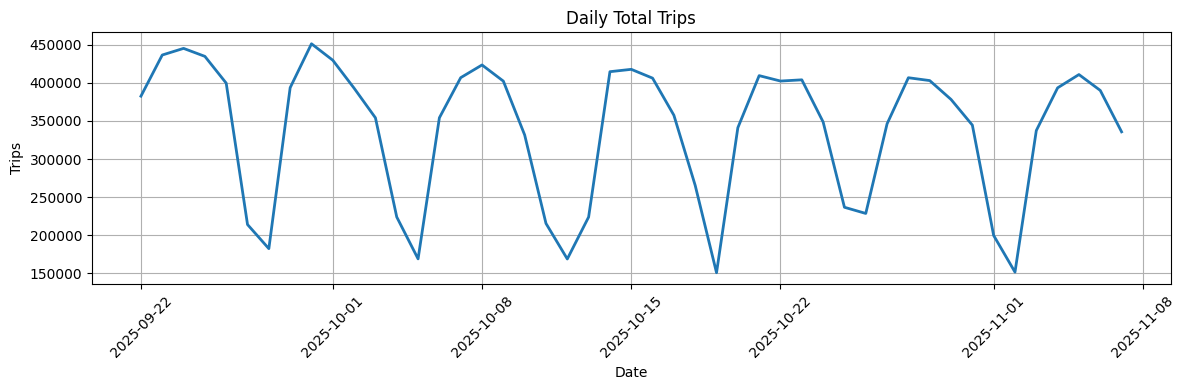

In [33]:
daily_trips = train_df.groupby("Entry date")["Trips"].sum().reset_index()

plt.figure(figsize=(12, 4))
plt.plot(daily_trips["Entry date"], daily_trips["Trips"], marker="", linewidth=2)
plt.title("Daily Total Trips")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Entropy in OD: A lower entropy indicates that the traffic flow is concentrated on certain routes.

        date  od_entropy  num_active_od  total_trips
0 2025-09-22    8.216006           9018     382567.0
1 2025-09-23    8.212671           9090     436577.0
2 2025-09-24    8.212865           9109     445281.0
3 2025-09-25    8.216139           9074     434799.0
4 2025-09-26    8.239116           9035     399668.0


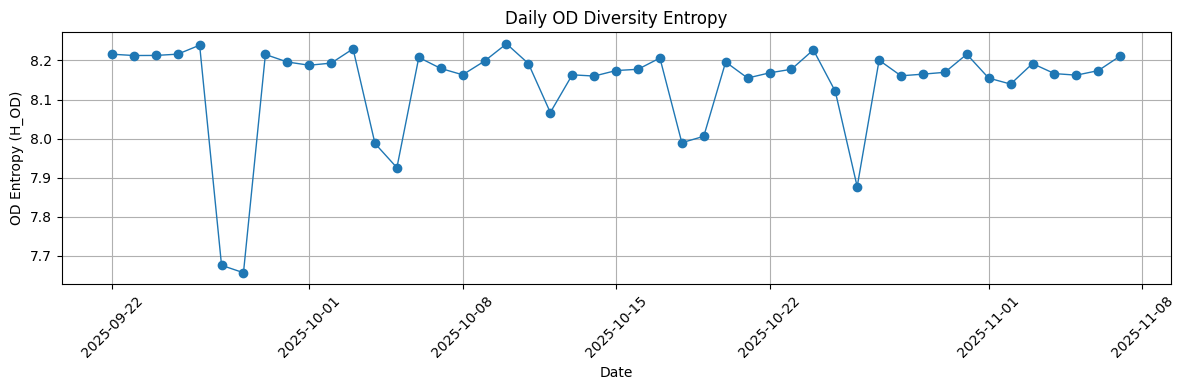

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_daily_od_entropy(df,
                             date_col="Entry date",
                             entry_col="Entry station",
                             exit_col="Exit station",
                             trips_col="Trips",
                             log_base="e"):
    """
    计算每日 OD 多样性熵 H_OD(t)

    log_base: 'e' -> 自然对数, '2' -> log2
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # 1. 每天每个 OD 的总 Trips
    daily_od = (
        df.groupby([date_col, entry_col, exit_col])[trips_col]
        .sum()
        .reset_index()
    )

    # 2. 对每一天计算熵
    entropies = []

    for date, g in daily_od.groupby(date_col):
        trips = g[trips_col].values.astype(float)
        total = trips.sum()
        if total <= 0:
            H = 0.0
        else:
            p = trips / total
            # 去掉 p=0 的项（防止 log 出 nan），其实 math 上它们本来就不贡献熵
            p = p[p > 0]
            if log_base == "2":
                logp = np.log2(p)
            else:
                logp = np.log(p)  # 自然对数
            H = -np.sum(p * logp)

        entropies.append({
            "date": date,
            "od_entropy": H,
            "num_active_od": len(g),   # 顺便记录当日活跃 OD 数量
            "total_trips": total
        })

    entropy_df = pd.DataFrame(entropies).sort_values("date").reset_index(drop=True)
    return entropy_df

# 使用：
entropy_df = compute_daily_od_entropy(train_df,
                                      date_col="Entry date",
                                      entry_col="Entry station",
                                      exit_col="Exit station",
                                      trips_col="Trips",
                                      log_base="e")

print(entropy_df.head())

# 画 OD 熵随时间的折线图
plt.figure(figsize=(12, 4))
plt.plot(entropy_df["date"], entropy_df["od_entropy"], marker="o", linewidth=1)
plt.xlabel("Date")
plt.ylabel("OD Entropy (H_OD)")
plt.title("Daily OD Diversity Entropy")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

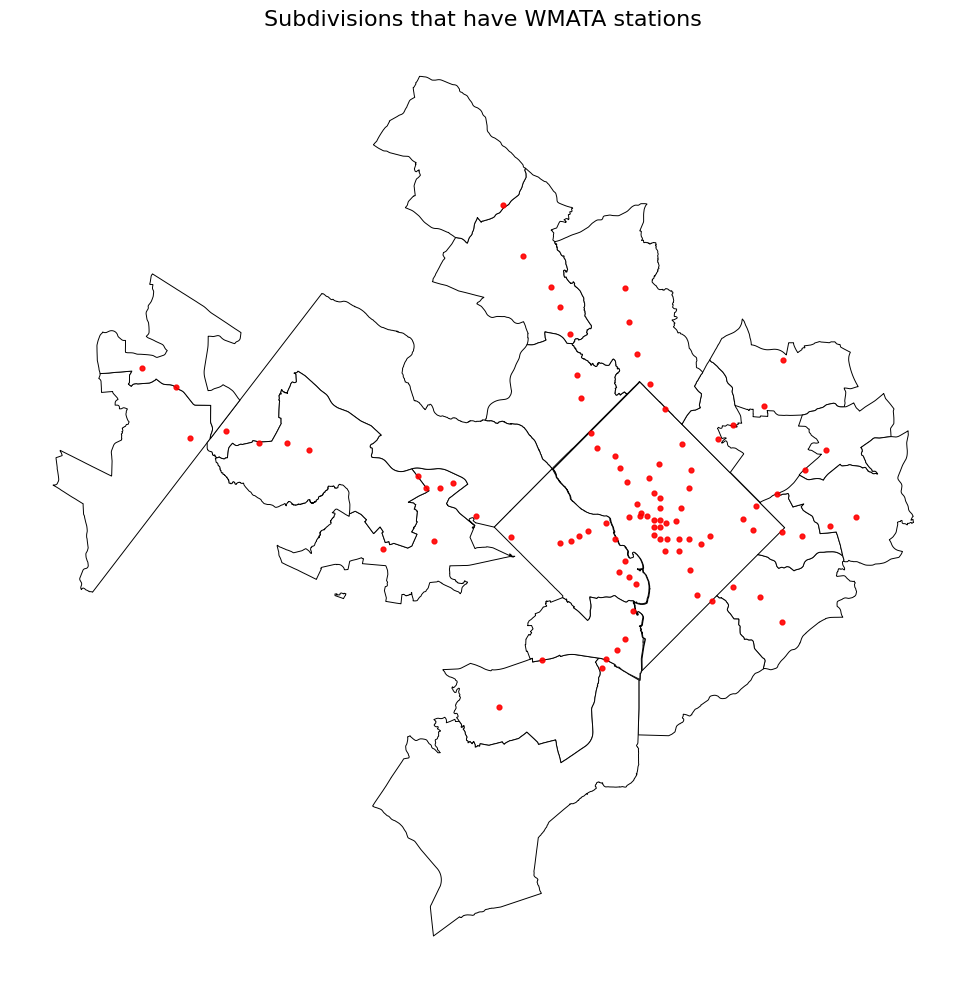

In [77]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. 读入华盛顿特区边界
dc_boundary_path = "DC_bike/gis/Washington_DC_Boundary/Washington_DC_Boundary.shp"
dc_boundary = gpd.read_file(dc_boundary_path)

# 2. 读入 Maryland COUSUB 并筛选两个县
maryland_boundary_path = "DC_bike/gis/tl_2022_24_cousub/tl_2022_24_cousub.shp"
maryland_boundary = gpd.read_file(maryland_boundary_path)
maryland_boundary = maryland_boundary[maryland_boundary["COUNTYFP"].isin(["031", "033"])]

# 3. 读入 Virginia COUSUB 并筛选几个县
virginia_boundary_path = "DC_bike/gis/tl_2021_51_cousub/tl_2021_51_cousub.shp"
virginia_boundary = gpd.read_file(virginia_boundary_path)
virginia_boundary = virginia_boundary[virginia_boundary["COUNTYFP"].isin(["010", "013", "059", "107"])]

alexandira_boundary_path = "DC_bike/gis/Alexandria_boundary/Boundary.shp"
alexandira_boundary = gpd.read_file(alexandira_boundary_path)

# 4. 坐标系统一
if maryland_boundary.crs != dc_boundary.crs:
    maryland_boundary = maryland_boundary.to_crs(dc_boundary.crs)
if virginia_boundary.crs != dc_boundary.crs:
    virginia_boundary = virginia_boundary.to_crs(dc_boundary.crs)
if alexandira_boundary.crs != dc_boundary.crs:
    alexandira_boundary = alexandira_boundary.to_crs(dc_boundary.crs)

# 5. 读入地铁站 CSV，构造 GeoDataFrame
stations_path = "DC_bike/gis/Metro_Stations_Regional.csv"
df = pd.read_csv(stations_path)
df["X"] = df["X"].astype(str).str.replace(" ", "")
df["Y"] = df["Y"].astype(str).str.replace(" ", "")
df["X"] = df["X"].astype(float)
df["Y"] = df["Y"].astype(float)
stations_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["X"], df["Y"]),
    crs=dc_boundary.crs
)

# 6. 合并行政区图层为一个大图层（Maryland + Virginia）
cousub_all = pd.concat([maryland_boundary, virginia_boundary, alexandira_boundary], ignore_index=True)

# 7. 空间连接：找到每个车站点属于哪个子区划
join_gdf = gpd.sjoin(stations_gdf, cousub_all, how="inner", predicate="within")

# 8. 从连接结果提取 “有车站”的子区划
covered_subdivisions = cousub_all[
    cousub_all["COUSUBFP"].isin(join_gdf["COUSUBFP"].unique())
]

# 9. 绘图：只画这些含车站的子区划 + 地铁站点
fig, ax = plt.subplots(figsize=(10, 10))
dc_boundary.plot(ax=ax, edgecolor="black", facecolor="white", linewidth=1)
covered_subdivisions.plot(ax=ax, edgecolor="black", facecolor="white", linewidth=0.7)
stations_gdf.plot(ax=ax, color="red", markersize=12, alpha=0.9)
ax.set_title("Subdivisions that have WMATA stations", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [83]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from shapely.geometry import Point
import os

# --- 配置部分 ---
stations_xlsx = "DC_bike/rail_OD_092225_110725.xlsx"  # 包含 Entry date, Entry station, Exit station, Trips 等
stations_loc_csv = "DC_bike/gis/Metro_Stations_Regional.csv"  # 包含 X, Y 坐标的每个站
boundary_shp = "DC_bike/gis/Washington_DC_Boundary/Washington_DC_Boundary.shp"  # 地图边界

output_folder = "daily_maps"
os.makedirs(output_folder, exist_ok=True)

# --- 读入站台位置 ---  
df_loc = pd.read_csv(stations_loc_csv)
df_loc["X"] = df_loc["X"].astype(float)
df_loc["Y"] = df_loc["Y"].astype(float)
gdf_loc = gpd.GeoDataFrame(df_loc, geometry=gpd.points_from_xy(df_loc["X"], df_loc["Y"]))
# 给定坐标系，根据你的边界系来设定，比如:
boundary = gpd.read_file(boundary_shp)
gdf_loc.set_crs(boundary.crs, inplace=True)

# --- 读入流量数据 ---  
df_flow = pd.read_excel(stations_xlsx, parse_dates=["Entry date"])
# 假设字段例如: Entry date, Entry station, Exit station, Trips
# 先按日期 + 站台统计“流入” (Entry station) 和 “流出” (Exit station)
flow_in  = df_flow.groupby(["Entry date", "Entry station"])["Trips"].sum().reset_index().rename(columns={"Entry station":"station", "Trips":"in_trips"})
flow_out = df_flow.groupby(["Entry date", "Exit station"])["Trips"].sum().reset_index().rename(columns={"Exit station":"station", "Trips":"out_trips"})

# 合并流入和流出数据
flow = pd.merge(flow_in, flow_out, on=["Entry date","station"], how="outer").fillna(0)
# --- 前面读入位置、流量数据等部分保持不变 ---

# 计算统一范围
vmin_in  = flow["in_trips"].min()
vmax_in  = flow["in_trips"].max()
vmin_out = flow["out_trips"].min()
vmax_out = flow["out_trips"].max()

for date, sub in flow.groupby("Entry date"):
    df_map = pd.merge(
        gdf_loc.drop(columns="geometry"),
        sub,
        left_on="NAME",
        right_on="station",
        how="left"
    ).fillna(0)
    gdf_map = gpd.GeoDataFrame(df_map, geometry=gdf_loc["geometry"], crs=gdf_loc.crs)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    
    # 底图：DC + 周边区县
    boundary.plot(ax=ax1,      edgecolor="black", facecolor="none")
    maryland_boundary.plot(ax=ax1,      edgecolor="black", facecolor="none", linewidth=0.5)
    virginia_boundary.plot(ax=ax1,      edgecolor="black", facecolor="none", linewidth=0.5)
    
    boundary.plot(ax=ax2,      edgecolor="black", facecolor="none")
    maryland_boundary.plot(ax=ax2,      edgecolor="black", facecolor="none", linewidth=0.5)
    virginia_boundary.plot(ax=ax2,      edgecolor="black", facecolor="none", linewidth=0.5)
    
    # 流入量子图（左） — 使用统一 vmin/vmax
    sc1 = ax1.scatter(
        gdf_map.geometry.x, gdf_map.geometry.y,
        c=gdf_map["in_trips"],
        cmap="YlOrRd",
        vmin=vmin_in, vmax=vmax_in,
        s=20, edgecolor="k", linewidth=0.3
    )
    ax1.set_title(f"{date.date()} - flow in")
    ax1.axis("off")
    cbar1 = fig.colorbar(
        mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin_in, vmax=vmax_in), cmap="YlOrRd"),
        ax=ax1, fraction=0.046, pad=0.04
    )
    cbar1.set_label("Trips (in)")
    
    # 流出量子图（右） — 使用统一 vmin/vmax
    sc2 = ax2.scatter(
        gdf_map.geometry.x, gdf_map.geometry.y,
        c=gdf_map["out_trips"],
        cmap="GnBu",
        vmin=vmin_out, vmax=vmax_out,
        s=20, edgecolor="k", linewidth=0.3
    )
    ax2.set_title(f"{date.date()} - flow out")
    ax2.axis("off")
    cbar2 = fig.colorbar(
        mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin_out, vmax=vmax_out), cmap="GnBu"),
        ax=ax2, fraction=0.046, pad=0.04
    )
    cbar2.set_label("Trips (out)")
    
    plt.suptitle(f"Station flows on {date.date()}", fontsize=16)
    plt.tight_layout()
    output_path = os.path.join(output_folder, f"flows_{date.date()}.png")
    plt.savefig(output_path, dpi=300)
    plt.close(fig)

In [93]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from shapely.geometry import Point

# --- 配置部分 ---
stations_xlsx    = "DC_bike/rail_OD_092225_110725.xlsx"            # 包含 Entry date, Entry station, Exit station, Trips 等
stations_loc_csv = "DC_bike/gis/Metro_Stations_Regional.csv"       # 包含 X, Y 坐标的每个站
boundary_shp     = "DC_bike/gis/ANC_boundary/Advisory_Neighborhood_Commissions_from_2023.shp"  # 地图边界

output_folder = "daily_maps_heatmap"
os.makedirs(output_folder, exist_ok=True)

# 如果你已经在别处读过 maryland_boundary / virginia_boundary，这里略过
# 否则记得补上它们的读取和 CRS 统一

# --- 读入站台位置 ---  
df_loc = pd.read_csv(stations_loc_csv)
df_loc["X"] = df_loc["X"].astype(float)
df_loc["Y"] = df_loc["Y"].astype(float)
gdf_loc = gpd.GeoDataFrame(df_loc, geometry=gpd.points_from_xy(df_loc["X"], df_loc["Y"]))

boundary = gpd.read_file(boundary_shp)
# 确定坐标系一致
gdf_loc.set_crs(boundary.crs, inplace=True)

# --- 读入流量数据 ---  
df_flow = pd.read_excel(stations_xlsx, parse_dates=["Entry date"])

# 先按日期 + 站台统计“流入” (Entry station) 和 “流出” (Exit station)
flow_in  = (
    df_flow.groupby(["Entry date", "Entry station"])["Trips"]
    .sum()
    .reset_index()
    .rename(columns={"Entry station": "station", "Trips": "in_trips"})
)
flow_out = (
    df_flow.groupby(["Entry date", "Exit station"])["Trips"]
    .sum()
    .reset_index()
    .rename(columns={"Exit station": "station", "Trips": "out_trips"})
)

# 合并流入和流出数据
flow = pd.merge(flow_in, flow_out, on=["Entry date", "station"], how="outer").fillna(0)

# === ✅ 在这里对数据取对数 ===
flow["log_in"]  = np.log1p(flow["in_trips"])   # log(1 + in_trips)
flow["log_out"] = np.log1p(flow["out_trips"])  # log(1 + out_trips)

# --- 统一 colorbar 范围（用对数后的值） ---
vmin_in  = flow["log_in"].min()
vmax_in  = flow["log_in"].max()
vmin_out = flow["log_out"].min()
vmax_out = flow["log_out"].max()

# --- 主绘图循环：每个日期一张图（两子图：流入 & 流出） ---
for date, sub in flow.groupby("Entry date"):
    # 合并位置 + 流量（包含 log_in / log_out）
    df_map = pd.merge(
        gdf_loc.drop(columns="geometry"),
        sub,
        left_on="NAME",
        right_on="station",
        how="left"
    ).fillna(0)
    gdf_map = gpd.GeoDataFrame(df_map, geometry=gdf_loc["geometry"], crs=gdf_loc.crs)

    # 提取坐标 & 权重（用对数后的权重）
    xs_in  = gdf_map.geometry.x.values
    ys_in  = gdf_map.geometry.y.values
    wts_in = gdf_map["log_in"].values      # ✅ 对数后的流入

    xs_out  = xs_in
    ys_out  = ys_in
    wts_out = gdf_map["log_out"].values    # ✅ 对数后的流出

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    # 底图：DC + 周边区县
    boundary.plot(ax=ax1, edgecolor="black", facecolor="none")
    maryland_boundary.plot(ax=ax1, edgecolor="black", facecolor="none", linewidth=0.5)
    virginia_boundary.plot(ax=ax1, edgecolor="black", facecolor="none", linewidth=0.5)

    boundary.plot(ax=ax2, edgecolor="black", facecolor="none")
    maryland_boundary.plot(ax=ax2, edgecolor="black", facecolor="none", linewidth=0.5)
    virginia_boundary.plot(ax=ax2, edgecolor="black", facecolor="none", linewidth=0.5)

    # --- 左子图：流入 热力图（用 log 权重） ---
    sns.kdeplot(
        x=xs_in, y=ys_in, weights=wts_in,
        fill=True,
        thresh=0.05,
        levels=50,
        cmap="YlOrRd",
        bw_adjust=0.4,        # 带宽可按需要继续调
        gridsize=150,
        ax=ax1,
        zorder=0
    )
    ax1.set_title(f"{date.date()} - flow in (log heatmap)")
    ax1.axis("off")

    # colorbar（对应 log(1 + Trips)）
    norm1 = mpl.colors.Normalize(vmin=vmin_in, vmax=vmax_in)
    sm1   = mpl.cm.ScalarMappable(cmap="YlOrRd", norm=norm1)
    sm1.set_array([])
    cbar1 = fig.colorbar(sm1, ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label("log(1 + Trips in)")

    # --- 右子图：流出 热力图（用 log 权重） ---
    sns.kdeplot(
        x=xs_out, y=ys_out, weights=wts_out,
        fill=True,
        thresh=0.05,
        levels=50,
        cmap="GnBu",
        bw_adjust=0.4,
        gridsize=150,
        ax=ax2,
        zorder=0
    )
    ax2.set_title(f"{date.date()} - flow out (log heatmap)")
    ax2.axis("off")

    norm2 = mpl.colors.Normalize(vmin=vmin_out, vmax=vmax_out)
    sm2   = mpl.cm.ScalarMappable(cmap="GnBu", norm=norm2)
    sm2.set_array([])
    cbar2 = fig.colorbar(sm2, ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_label("log(1 + Trips out)")

    plt.suptitle(f"Station Flow Heatmap on {date.date()} (log scale)", fontsize=16)
    plt.tight_layout()
    output_path = os.path.join(output_folder, f"heatmap_flows_log_{date.date()}.png")
    plt.savefig(output_path, dpi=300)
    plt.close(fig)

## Graph based analysis

Dynamic community structure: by IterModmax

In [5]:
required_cols = ["Entry date", "Entry station", "Exit station", "Trips"]
missing = [c for c in required_cols if c not in train_df.columns]
if missing:
    raise ValueError(f"train_df missing required columns: {missing}")

train_df = train_df.rename(columns={
    "Entry date": "layer",
    "Entry station": "u",
    "Exit station": "v",
    "Trips": "weight",
})

In [13]:
undirected_df = (
    train_df
    # 给每条边找一个“无向”的规范端点顺序（小的在前，大的在后）
    .assign(
        u_min=lambda d: d[["u", "v"]].min(axis=1),
        v_max=lambda d: d[["u", "v"]].max(axis=1),
    )
    # 按 timestamp + 无向端点分组，把 weight 相加
    .groupby(["layer", "u_min", "v_max"], as_index=False)["weight"].sum()
    # 把规范端点名改回 u, v
    .rename(columns={"u_min": "u", "v_max": "v"})
)

# 结果 undirected_df 列：timestamp, u, v, weight

In [31]:
import algorithms, importlib
importlib.reload(algorithms)
from algorithms import *

train_community = genlouvain_communities(undirected_df, output_csv="DC-train-comm.csv", weight=True, algorithm='iterated')

/var/folders/6r/8pf7t78x2jz69wslwjn4r2sc0000gn/T/ipykernel_17584/1838707140.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap('tab20', num_comms)  # 至少 16 色够用


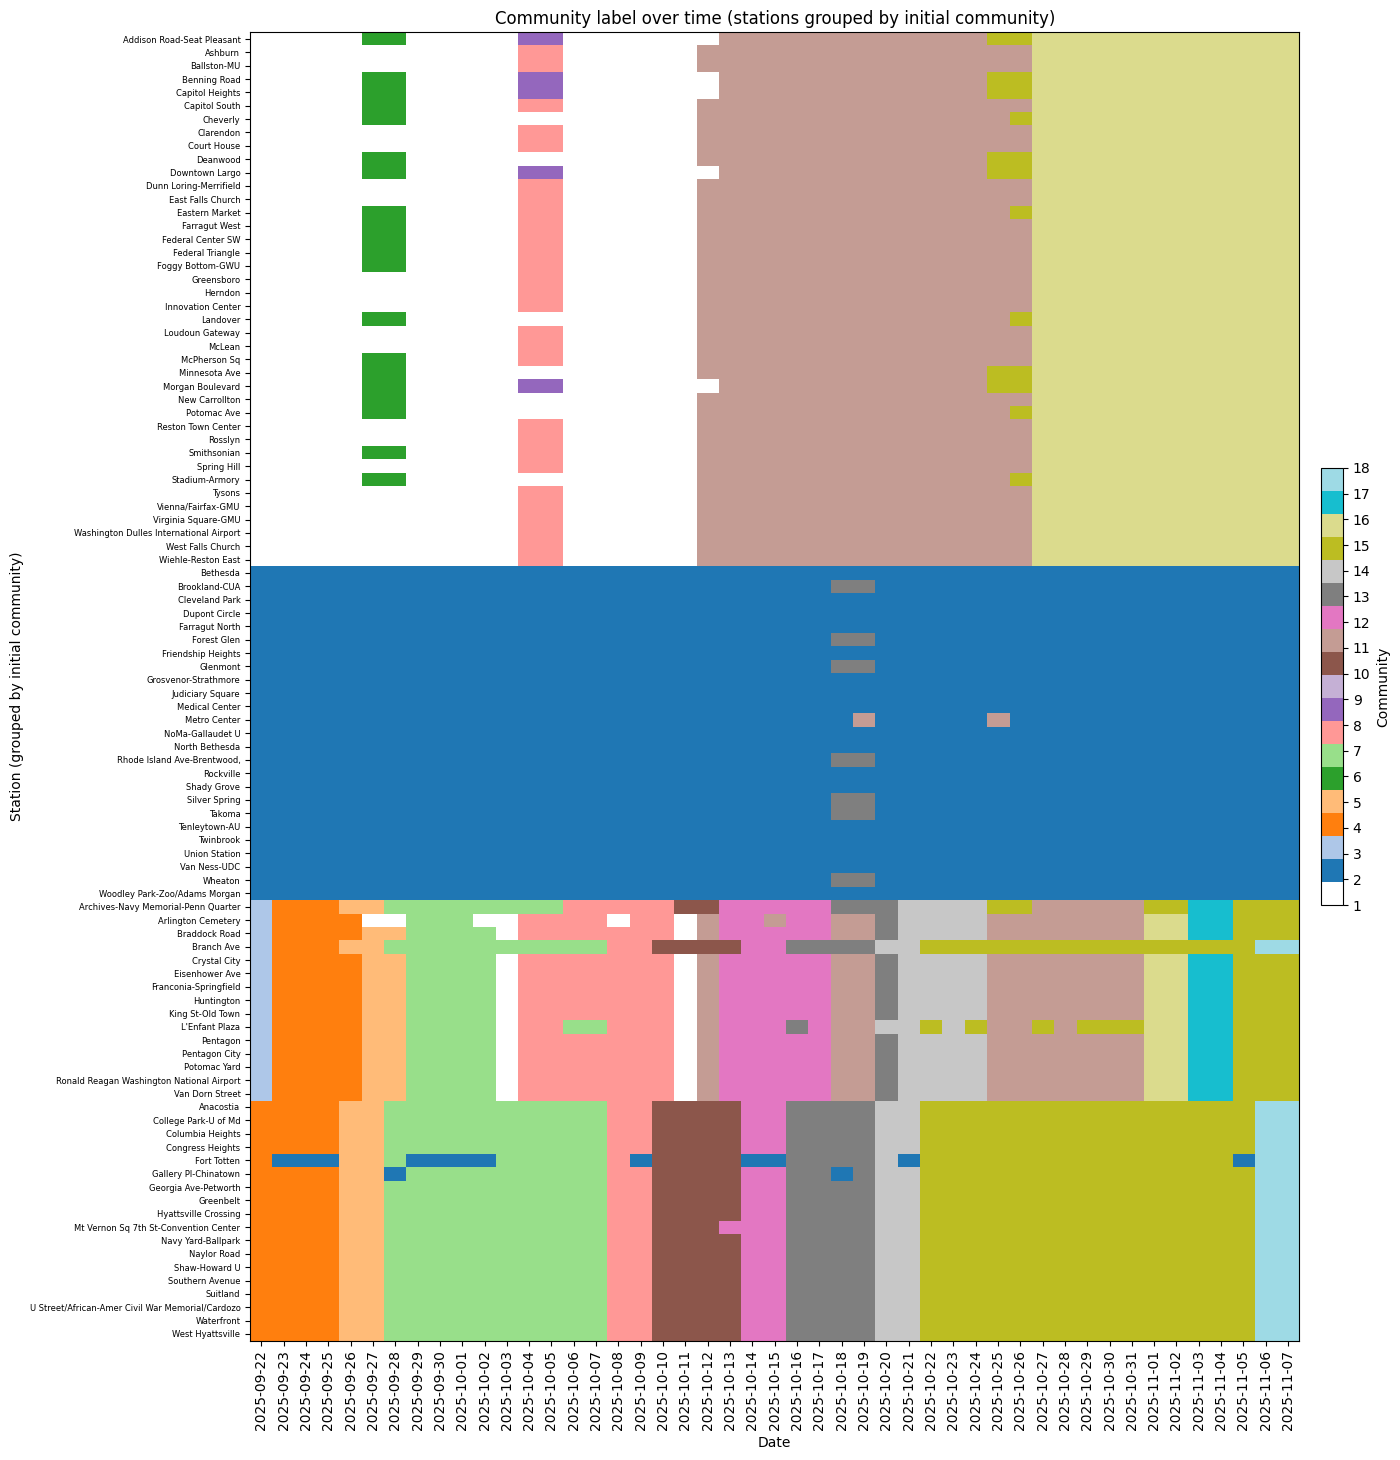

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 假设 df 有三列：date, station, community
# 如果你的列名不同，比如 '日期'、'站台'、'标签'，在这里改一下就行
df = train_community
df['layer'] = pd.to_datetime(df['layer'])

# 1. 计算每个站台的“初始社区”（最早日期的社区标签）
first_comm = (
    df.sort_values('layer')
      .groupby('node_id', as_index=False)
      .first()[['node_id', 'community']]
      .rename(columns={'community': 'initial_community'})
)

df = df.merge(first_comm, on='node_id', how='left')

# 2. 按“初始社区 + 站台名”排序，得到纵轴顺序
station_order = (
    df[['node_id', 'initial_community']]
    .drop_duplicates()
    .sort_values(['initial_community', 'node_id'])
    ['node_id']
    .tolist()
)

# 3. 日期顺序（横轴）
date_order = sorted(df['layer'].unique())

# 4. 透视成矩阵：行=station，列=date，值=community
mat = (
    df.set_index(['node_id', 'layer'])['community']
      .unstack('layer')
      .reindex(index=station_order, columns=date_order)
)

# 5. 社区标签映射成整数 code，用于绘图
# 如果 community 本来就是 0~15 之类的整数，这一步也可以省略
communities = pd.Categorical(mat.stack())  # 去掉 NaN 后做类别
comm_to_code = {cat: i for i, cat in enumerate(communities.categories)}
code_to_comm = {i: cat for cat, i in comm_to_code.items()}

mat_codes = mat.replace(comm_to_code).to_numpy()

# 处理缺失值（如果某站台某天没标签）：设置为 -1，用白色或透明显示
mask_nan = np.isnan(mat_codes)
mat_codes = np.where(mask_nan, -1, mat_codes).astype(int)

# 6. 构造离散 colormap（16 个社区就 16 种颜色）
num_comms = len(comm_to_code)

base_cmap = plt.cm.get_cmap('tab20', num_comms)  # 至少 16 色够用
colors = base_cmap(range(num_comms))
# 在前面加一个专门给 -1（缺失）的颜色，比如白色
colors = np.vstack([[1, 1, 1, 1], colors])  # 第一行给 -1 用
cmap = ListedColormap(colors)

# 把 code +1，这样 -1 -> 0（白色），0..num_comms-1 -> 1..num_comms
mat_plot = mat_codes + 1

# 7. 画图
fig, ax = plt.subplots(figsize=(len(date_order) * 0.3, len(station_order) * 0.15))

im = ax.imshow(
    mat_plot,
    aspect='auto',
    interpolation='nearest',
    cmap=cmap,
)

# 坐标轴刻度
ax.set_xticks(range(len(date_order)))
ax.set_xticklabels([d.strftime('%Y-%m-%d') for d in date_order], rotation=90)

ax.set_yticks(range(len(station_order)))
ax.set_yticklabels(station_order, fontsize=6)  # 98 个站台字体可以小一点

ax.set_xlabel('Date')
ax.set_ylabel('Station (grouped by initial community)')
ax.set_title('Community label over time (stations grouped by initial community)')

# 8. 加 colorbar，并把整数 code 映射回原始社区标签
cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
cbar_ticks = np.arange(1, num_comms + 1)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([code_to_comm[i] for i in range(num_comms)])
cbar.set_label('Community')

plt.tight_layout()
plt.show()